## Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import random
from tqdm import tqdm
import os
import cv2

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical

# Preparing the Data

##  Getting train and validation data

In [3]:
IMG_SIZE=150

FLOWER_DAISY_DIR = "flowers/daisy/"
FLOWER_DANDELION_DIR = "flowers/dandelion/"
FLOWER_ROSE_DIR = "flowers/rose/"
FLOWER_SUNFLOWER_DIR = "flowers/sunflower/"
FLOWER_TULIP_DIR = "flowers/tulip/"

In [4]:
# Creating funtion to assign labels to each flower

def assign_labels(path, flower_type):
    label = str(flower_type)                # flower_type is nothing but the class label of the flower
    for img in tqdm(os.listdir(path)):      # os.listdir list all the files present in at the given location
        img_path = path + str(img)          # combining folder path and image files name
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       # Reading image file from the above location
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))        # Resizing image to dimensoion 150*150
        
        img_arr.append(np.array(img))       # Appending image value into a variable for further processing
        labels.append(label)                # Appending corresponding label name

In [5]:
# Following code will check for the presence of store image array and corresponding label in current working directory.
# If both files are present in CWD then we'll directly load that file to avoide re-processing

if os.path.isfile("img_arr.npy") and os.path.isfile("labels.npy"):
    print("Reading file....")
    img_arr = np.load("img_arr.npy")
    labels = np.load("labels.npy")
    print("Done...")
    
else:
                                            # Creating list for storing image value and labels
    img_arr = [] 
    labels = []

    print("Flower -> Daisy....")
    assign_labels(FLOWER_DAISY_DIR, "Daisy")  # calling function to assign label to all images present at given dir location
    
    print("Flower -> Dandelion....")
    assign_labels(FLOWER_DANDELION_DIR, "Dandelion")
    
    print("Flower -> Rose....")
    assign_labels(FLOWER_ROSE_DIR, "Rose")
    
    print("Flower -> Sunflower....")
    assign_labels(FLOWER_SUNFLOWER_DIR, "Sunflower")
    
    print("Flower -> Tuplip....")
    assign_labels(FLOWER_TULIP_DIR, "Tuplip")
    
                                               # Saving image and label array in cwd
    np.save("img_arr.npy", img_arr)
    np.save("labels.npy", labels)
    
    print("Done...")

Reading file....
Done...


In [6]:
type(img_arr)

numpy.ndarray

# Visualizing some Random Images

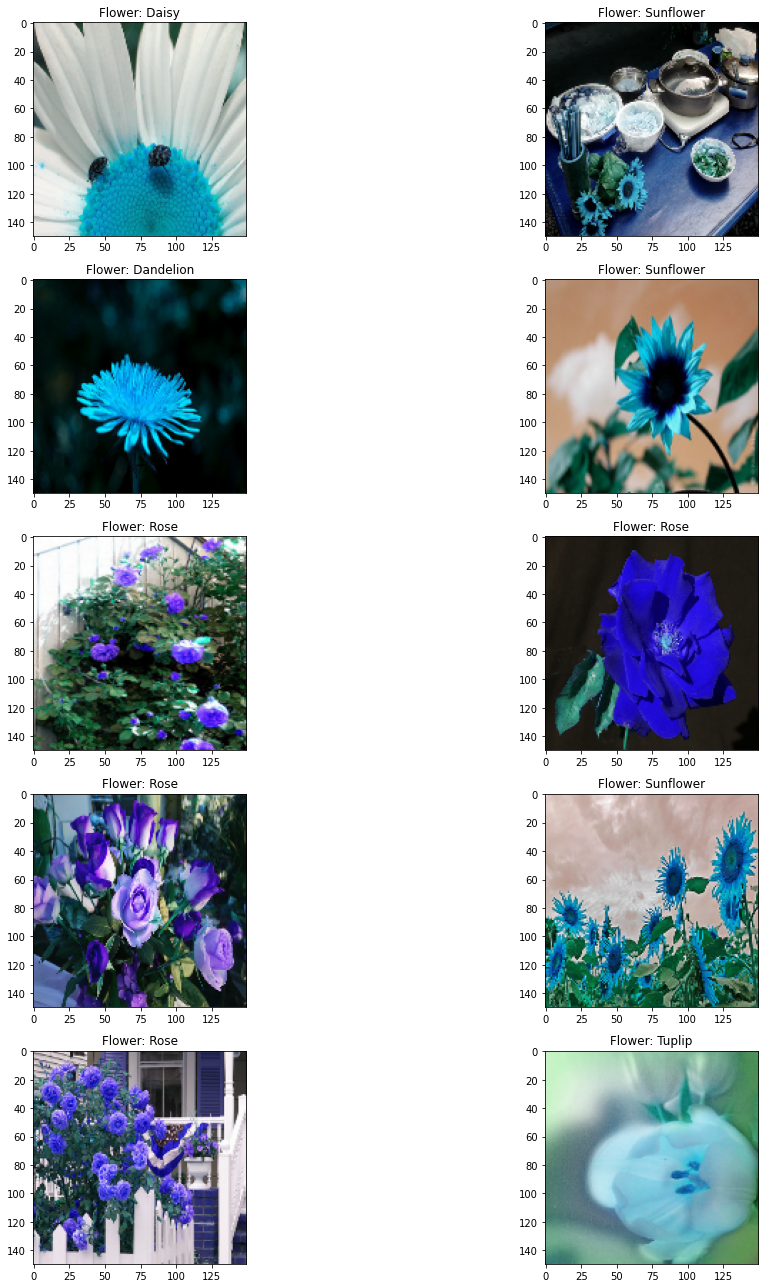

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(18,18)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(img_arr))
        ax[i,j].imshow(img_arr[l])
        ax[i,j].set_title('Flower: '+ str(labels[l]))
        
plt.tight_layout()

# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [8]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(labels) # Encoding all the labels into 0s and 1s
Y = to_categorical(Y,5)                 # As we are dealing with multiclass classification hear I'm performing onHotEncoding
X= np.array(img_arr)                    
X= X/255                                # Normalizing image array

In [9]:
# Spliting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [10]:
# Setting seed values

np.random.seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)

## Building Model

In [11]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation="relu", input_shape = (IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding="Same", activation= "relu"))
    model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

    model.add(Conv2D(filters = 96, kernel_size=(3,3), padding="Same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = 96, kernel_size= (3,3), padding="Same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(Dense(5, activation="softmax"))
    # Compiling the model
    model.compile(optimizer=Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
def fit_model(model):
    # Fitting on training set and using validation set
    
    batch_size = 128
    epochs = 50


    # ModelCheckpoint ->   Callback is used in conjunction with training using model.fit() to save a model or weights
    # ReduceLROnPlateau -> Reduce learning rate when a metric has stopped improving.
    # EarlyStoppingStop -> Stop training when a monitored metric has stopped improving

    # monitor: quantity to be monitored.
    # factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
    # patience: number of epochs with no improvement after which learning rate will be reduced.
    # verbose: int. 0: quiet, 1: update messages.
    # min_lr: lower bound on the learning rate.

    from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)
    mcp_save = ModelCheckpoint('mdl_wts.h5', save_best_only=True, monitor='val_accuracy', mode='auto')
    red_lr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor = 0.1)


    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                 epochs = 50, validation_data=(X_val, y_val),
                                 callbacks=[earlyStopping, mcp_save, red_lr],
                                 verbose= 1, steps_per_epoch = X_train.shape[0] // batch_size)
    
    plot_loss_acc(history)

## Data Agumentation

In [14]:
datagen = ImageDataGenerator(
    featurewise_center= False,    # set input mean to 0 over the dataset
    samplewise_center= False,     # set each sample mean to 0
    featurewise_std_normalization= False,   # divide inputs by std of the dataset
    samplewise_std_normalization= False,   # divide each input by its std
    zca_whitening= False,         # apply ZCA whitening
    rotation_range=10,            # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,             # Randomly zoom image 
    width_shift_range=0.2,        # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,       # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,         # randomly flip images
    vertical_flip=False          # randomly flip images

)

datagen.fit(X_train)

In [15]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()

Epoch 1/50
23/23 [==============================] - 15s 627ms/step - loss: 1.5233 - accuracy: 0.2955 - val_loss: 1.3336 - val_accuracy: 0.4352 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 12s 524ms/step - loss: 1.2193 - accuracy: 0.4770 - val_loss: 1.2886 - val_accuracy: 0.4892 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 12s 520ms/step - loss: 1.1328 - accuracy: 0.5192 - val_loss: 1.1855 - val_accuracy: 0.4846 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 12s 519ms/step - loss: 1.0397 - accuracy: 0.5824 - val_loss: 0.9826 - val_accuracy: 0.6080 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 12s 512ms/step - loss: 0.9778 - accuracy: 0.6153 - val_loss: 1.0326 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 12s 517ms/step - loss: 0.9365 - accuracy: 0.6295 - val_loss: 0.9300 - val_accuracy: 0.6204 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 12s 513ms/st

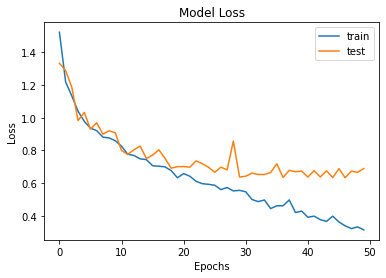

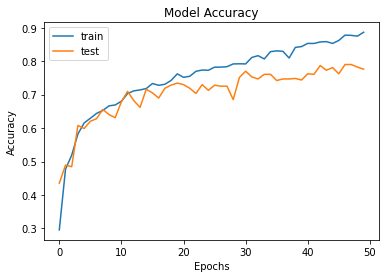

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 96)      

In [89]:
if os.path.isfile("model.h5"):
    model = load_model("model.h5")
    print(model.summary())
else:
    model = create_model()
    fit_model(model)
    model.save("model.h5")
    print(model.summary())

## Visualizing Predictons on the Validation Set

In [91]:
# getting predictions on val set.
pred=model.predict(X_test)
pred_digits=np.argmax(pred,axis=1)

In [92]:
len(pred_digits), len(y_test)

(648, 648)

In [93]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(X_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    else:
        mis_class.append(i)


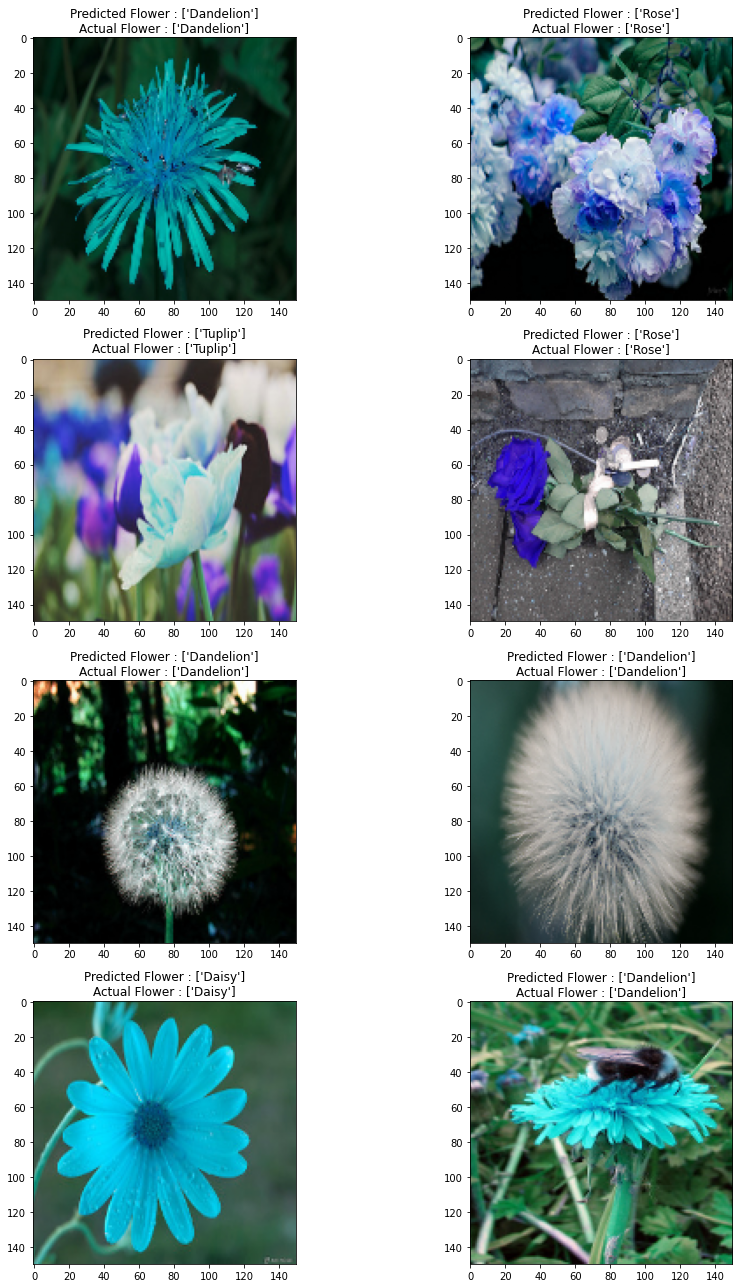

In [94]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(18,18)
for i in range (4):
    for j in range (2):
        count = random.choice(prop_class)
        ax[i,j].imshow(X_test[count])
        
        ax[i,j].set_title("Predicted Flower : "+str(label_encoder.inverse_transform([pred_digits[count]]))+"\n"+"Actual Flower : "+str(label_encoder.inverse_transform([np.argmax([y_test[count]])])))
        plt.tight_layout()
        count+=1

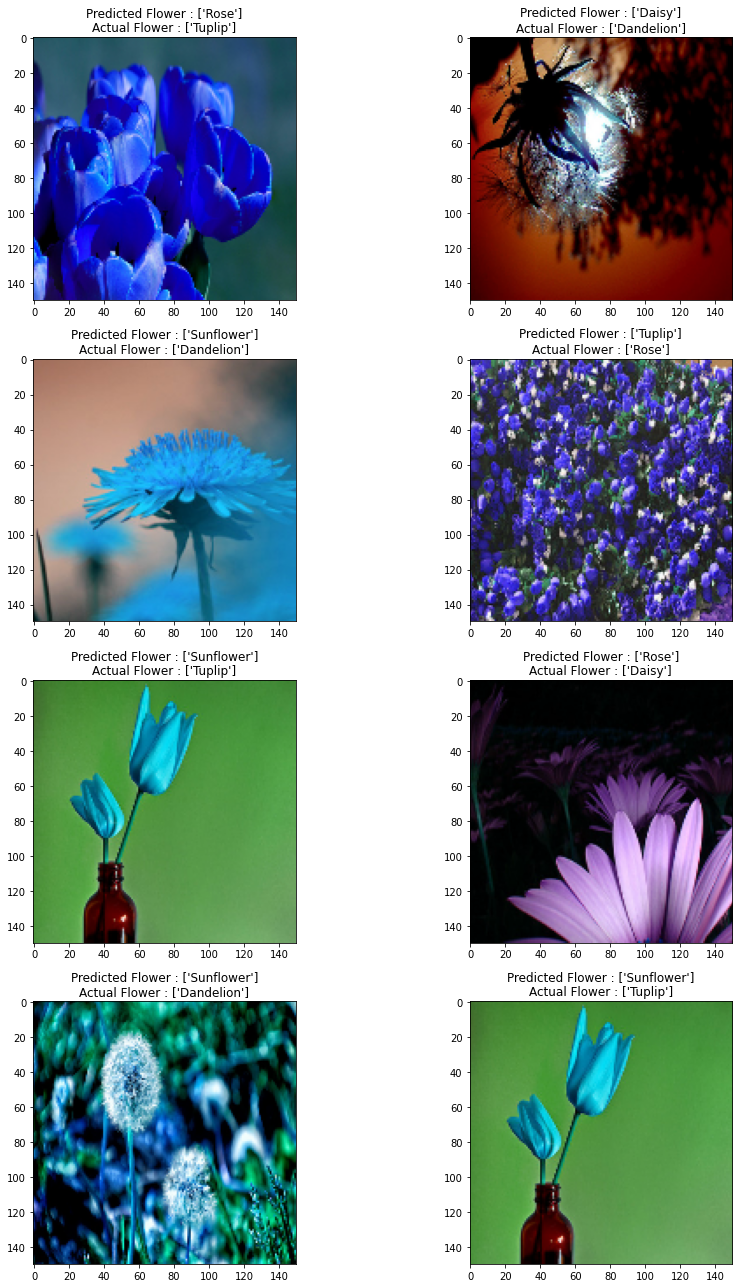

In [95]:
fig,ax=plt.subplots(4,2)
fig.set_size_inches(18,18)
for i in range (4):
    for j in range (2):
        count = random.choice(mis_class)
        ax[i,j].imshow(X_test[count])
        
        ax[i,j].set_title("Predicted Flower : "+str(label_encoder.inverse_transform([pred_digits[count]]))+"\n"+"Actual Flower : "+str(label_encoder.inverse_transform([np.argmax([y_test[count]])])))
        plt.tight_layout()
        count+=1

In [96]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    
    labels = [0,1,2,3,4]
    # representing A in heatmap format
    cmap=sn.light_palette("blue")
    plt.subplot(1, 3, 1)
    sn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    print(label_encoder.inverse_transform(labels)) # [0,1,2,3,4] - > ['Daisy' 'Dandelion' 'Rose' 'Sunflower' 'Tuplip']
    plt.show()

['Daisy' 'Dandelion' 'Rose' 'Sunflower' 'Tuplip']


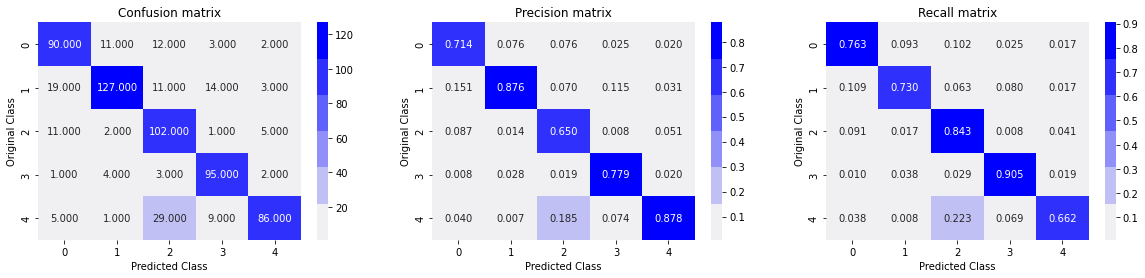

In [97]:
y_actual = [np.argmax(x) for x in y_test]
plot_confusion_matrix(y_actual, pred_digits)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, pred_digits, digits = 4))

              precision    recall  f1-score   support

           0     0.7143    0.7627    0.7377       118
           1     0.8759    0.7299    0.7962       174
           2     0.6497    0.8430    0.7338       121
           3     0.7787    0.9048    0.8370       105
           4     0.8776    0.6615    0.7544       130

    accuracy                         0.7716       648
   macro avg     0.7792    0.7804    0.7718       648
weighted avg     0.7888    0.7716    0.7721       648

